# 2021/1/8
# 绘制论文version1.3中的图fig7 （增补）
# 内容为 流函数等值线，散度风矢量，散度shading

In [1]:
import os
import sys
import xarray as xr
import numpy as np
module_path = ["/home/sun/mycode/module/","/data5/2019swh/mycode/module/"]
sys.path.append(module_path[0])
from module_sun import *
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.units import units
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib as mpl

In [2]:
path  =  "/home/sun/qomo-data/"
f1  =  xr.open_dataset(path+"composite-merra2-single.nc")
f2  =  xr.open_dataset(path+'composite-single_merra2_stream_vp_function.nc')

disy,disx,location = cal_xydistance(f2.lat,f2.lon)

# 使用势函数计算散度风
v  = np.gradient(f2.velocity_potential_function.data,location,axis=1)
u  = copy.deepcopy(v)
for i in range(1,180):
    u[:,i,:] = np.gradient(f2.velocity_potential_function.data[:,i,:],disx[i],axis=1)
    
# 计算散度
vy  =  np.gradient(f1.V2M,location,axis=1)
ux = copy.deepcopy(vy)
for i in range(1,len(f1.lat)-1):
    ux[:,i,:] = np.gradient(f1.U2M.data[:,i,:],disx[i],axis=1)
    
div  =  1e6*(ux+vy)

# 计算涡度

uy  =  np.gradient(f1.U2M,location,axis=1)
vx  = copy.deepcopy(uy)
for i in range(1,len(f1.lat)-1):
    vx[:,i,:] = np.gradient(f1.V2M.data[:,i,:],disx[i],axis=1)
    
vorticity  =  1e6*(vx-uy)
    


In [4]:
mask_file  =  xr.open_dataset(path+'MERRA2_land_sea_mask.nc')

# 插值
interp_mask1  =  np.zeros((len(mask_file.lat),len(f1.lon)))
interp_mask2  =  np.zeros((len(f1.lat),len(f1.lon)))

for i in range(len(mask_file.lat)):
    interp_mask1[i,:]  =  np.interp(f1.lon,mask_file.lon,mask_file.FRLAND[0,i,:])

for i in range(len(f1.lon)):
    interp_mask2[:,i]  =  np.interp(f1.lat,mask_file.lat,interp_mask1[:,i])
    
# 屏蔽掉陆地
for i in range(len(f1.lat)):
    for j in range(len(f1.lon)):
        for z in range(35):
            if interp_mask2[i,j] > 0.5:
                div[z,i,j] = np.nan
                vorticity[z,i,j] = np.nan
            else:
                continue
    
# 打包
ncfile   =  xr.Dataset(
    {
        "u": (["time","lat", "lon"], u),
        "v": (["time","lat","lon"], v),
        "div": (["time","lat","lon"], div),
        "vorticity": (["time","lat","lon"], vorticity),
    },
    coords={
        "lon": (["lon"], f2.lon.data),
        "lat": (["lat"], f2.lat.data),
        "time": (["time"], f2.time.data),
    },
)
ncfile.attrs["description"]  =  "divergent wind"

mask_file   =  xr.Dataset(
    {
        "mask_1x1": (["lat", "lon"], interp_mask2),
    },
    coords={
        "lon": (["lon"], f1.lon.data),
        "lat": (["lat"], f1.lat.data),
    },
)
mask_file.attrs["description"]  =  "mask merra2 1*1"
mask_file.to_netcdf("/home/sun/data/merra2_mask_1x1.nc")

## 画图

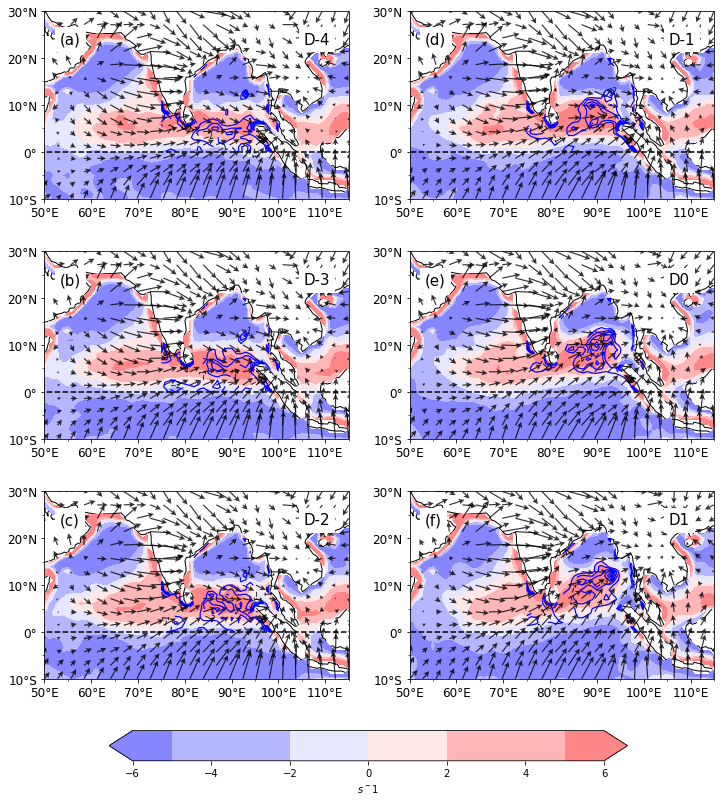

In [9]:
lonmin,lonmax,latmin,latmax  =  50,115,-10,30
extent     =  [lonmin,lonmax,latmin,latmax]
lon_slice  =  slice(40,120)
lat_slice  =  slice(-15,40)

f1  =  ncfile.sel(lon=slice(75,100),lat=slice(0,20)) 
#f1  =  ncfile.sel(lon=lon_slice,lat=lat_slice)  
f2  =  xr.open_dataset(path+'composite-single_merra2_stream_vp_function.nc').sel(lon=lon_slice,lat=lat_slice) 
f3  =  ncfile.sel(lon=lon_slice,lat=lat_slice) 
f4  =  ncfile.sel(lon=lon_slice,lat=lat_slice)

date  =  [-4,-3,-2,-1,0,1]
dates =  [26,27,28,29,30,31]

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('seismic', 22)
newcolors = viridis(np.linspace(0.4, 0.6, 20))
newcmp = ListedColormap(newcolors)
#newcmp.set_under('white')
#newcmp.set_over('white')

number =  ["a","b","c","d","e","f"]
props = dict(boxstyle='square', edgecolor='white', facecolor='white', alpha=1)

proj    =  ccrs.PlateCarree()
fig1    =  plt.figure(figsize=(12,14))
spec1   =  fig1.add_gridspec(nrows=3,ncols=2)

j = 0
    
for col in range(2):
    for row in range(3):
            ax = fig1.add_subplot(spec1[row,col],projection=proj)
            ax.coastlines(resolution='110m',lw=1)
            # 设置经纬度刻度.
            set_map_ticks(ax, dx=10, dy=10, nx=1, ny=1, labelsize='large')
            ax.set_extent(extent, crs=proj)
            
            ax.plot([40,120],[0,0],'k--')
            im1  =  ax.contourf(f4.lon,f4.lat,f4.vorticity.data[dates[j],:],np.linspace(-6,6,13),cmap=newcmp,alpha=1,extend='both')
            im2  =  ax.contour(f1.lon,f1.lat,f1.div.data[dates[j],:],np.linspace(-6,-1,6),colors='b',alpha=1,linewidths=1.2,linestyles='solid')
            ax.clabel(im2, np.linspace(-6,-1,6),inline=True, fontsize=8,colors='k')
            q  =  ax.quiver(f3.lon, f3.lat, f3.u.data[dates[j],:], f3.v.data[dates[j],:], 
                            regrid_shape=15, angles='uv',   # regrid_shape这个参数越小，是两门就越稀疏
                            scale_units='xy', scale=0.5,        # scale是参考矢量，所以取得越大画出来的箭头就越短
                            units='xy', width=0.25,
                            transform=proj,
                            color='k',linewidth=1.2,headlength = 5, headaxislength = 4, headwidth = 5,alpha=0.8)
            ax.text(0.85,0.825,"D"+str(date[j]),transform=ax.transAxes,bbox=props,fontsize=15)
            ax.text(0.05,0.825,"("+number[j]+")",transform=ax.transAxes,bbox=props,fontsize=15)
        
            j += 1

    
fig1.subplots_adjust(top=0.8) 
cbar_ax = fig1.add_axes([0.2, 0.05, 0.6, 0.03]) 
fig1.colorbar(im1, cax=cbar_ax, shrink=0.1, pad=0.01, orientation='horizontal',label='${s^-1}$')

plt.savefig("/home/sun/paint/lunwen/version1.3-20220108/fig7_version1.3_2m_div_streamfunction_divwind.pdf",dpi=300)

In [23]:
f1.div.data.shape

(61, 42, 111, 129)